<a href="https://colab.research.google.com/github/fowardelcac/Portafolio_Ciencia_de_Datos/blob/main/Notebooks/app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.optimize as sci_opt

In [2]:
def chart_frontera(df_frontera, max_sh, min_vol, max_ret):
  fig = px.scatter(df_frontera, x='Volatibilidad', y='Retornos', color='Sharpe',
                 labels={'Volatibilidad': 'Volatibilidad esperada', 'Retornos': 'Retornos esperados'},
                 title='Portfolio Optimization',
                 hover_data={'Volatibilidad': True, 'Retornos': True, 'Sharpe': True})

  fig.add_scatter(x=[min_vol[1]], y=[min_vol[0]], mode='markers', marker=dict(color='red', symbol='star', size=20), name='Volatibilidad minima esperada')
  fig.add_scatter(x=[max_ret[1]], y=[max_ret[0]], mode='markers', marker=dict(color='red', symbol='star', size=20), name='Retornos maximos esperados')
  fig.add_scatter(x=[max_sh[1]], y=[max_sh[0]], mode='markers', marker=dict(color='red', symbol='square', size=20), name='Maximo Sharpe Ratio')

  fig.update_layout(
      coloraxis=dict(colorscale='plasma', colorbar=dict(title='Sharpe Ratio')),
      legend=dict(
          title=None,
          orientation='h',
          yanchor='bottom',
          y=-0.2,
          xanchor='right',
          x=1
      ),
      margin=dict(l=0, r=0, t=30, b=0),
      showlegend=True,
      hovermode='closest',
      plot_bgcolor='white',
      paper_bgcolor='white',
      xaxis=dict(showgrid=True, title_font=dict(size=12)),
      yaxis=dict(showgrid=True, title_font=dict(size=12)),
  )

  fig.show()

In [12]:
def benchmark(cap, pesos, df):
  df = df / df.iloc[0]
  data1 = df.drop('^GSPC', axis=1)
  sp = df['^GSPC']
  dff = pd.DataFrame()
  indice = 0
  for i in data1:
      dff[i] = (data1[i] * pesos[indice]) * cap
      indice += 1


  dff['Value'] = dff.sum(axis=1)
  dff['SP500'] = (sp / sp.iloc[0]) * cap
  dff.dropna(inplace=True)
  return dff

In [3]:
assets = ['AAPL', 'MSFT', 'TSLA', '^GSPC']
assets_df = pd.DataFrame(columns=assets)
for i in assets:
  assets_df[i] = yf.download(i, '2015-01-01')['Adj Close']
df_retornos = np.log(assets_df / assets_df.shift(1)).dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
assets_df.head()

,AAPL,MSFT,TSLA,^GSPC
Date,,,,
2015-01-02,24.531765,40.620663,14.620667,2058.199951
2015-01-05,23.840668,40.247116,14.006000,2020.579956
2015-01-06,23.842911,39.656391,14.085333,2002.609985
2015-01-07,24.177242,40.160263,14.063333,2025.900024
2015-01-08,25.106184,41.341686,14.041333,2062.139893


In [5]:
df_ret = df_retornos.drop('^GSPC', axis=1)
n_iter, n_assets = 5000, 3
pf_returns, pf_vol, pf_sharpe = [list() for _ in range(3)]
all_weights = np.zeros((n_iter, n_assets))

Optimizacion de markowitz

In [6]:
for i in range(n_iter):
  weights = np.random.random(n_assets)

  weights = weights / np.sum(weights)
  all_weights[i, :] = weights

  ret_esp = np.sum(df_ret.mean() * weights) * 252
  vol_esp = np.sqrt(np.dot(weights.T, np.dot(df_ret.cov() * 252, weights)))
  sharpe = (ret_esp - 0.01) / vol_esp
  pf_returns.append(ret_esp)
  pf_vol.append(vol_esp)
  pf_sharpe.append(sharpe)

df_frontera = pd.DataFrame({
    'Retornos': pf_returns,
    'Volatibilidad': pf_vol,
    'Sharpe': pf_sharpe,
    'Pesos': np.round(all_weights, 3).tolist()
})

In [7]:
df_frontera.head()

,Retornos,Volatibilidad,Sharpe,Pesos
0,0.262973,0.288931,0.875547,"[0.549, 0.25, 0.201]"
1,0.267256,0.302994,0.849046,"[0.594, 0.15, 0.256]"
2,0.290819,0.346671,0.810044,"[0.062, 0.496, 0.442]"
3,0.248422,0.268343,0.888499,"[0.542, 0.423, 0.036]"
4,0.286690,0.337928,0.818784,"[0.208, 0.374, 0.418]"


In [8]:
max_sh = df_frontera.iloc[df_frontera.Sharpe.idxmax()]
min_vol = df_frontera.iloc[df_frontera.Volatibilidad.idxmin()]
max_ret = df_frontera.iloc[df_frontera.Retornos.idxmax()]
chart_frontera(df_frontera, max_sh, min_vol, max_ret)

In [20]:
max_sh.Pesos

[0.271, 0.616, 0.113]

In [22]:
bench_sharpe = benchmark(100000, max_sh.Pesos, assets_df)
bench_sharpe.head()

,AAPL,MSFT,TSLA,Value,SP500
Date,,,,,
2015-01-02,27100.000000,61600.000000,11300.000000,100000.000000,100000.000000
2015-01-05,26336.551640,61033.527937,10824.936382,98195.015959,98172.189485
2015-01-06,26339.029507,60137.711518,10886.251390,97362.992415,97299.097894
2015-01-07,26708.362247,60901.817962,10869.247821,98479.428030,98430.671095
2015-01-08,27734.555055,62693.410307,10852.244988,101280.210351,100191.426562


In [23]:
rdo_df = bench_sharpe.filter(['Value', 'SP500'], axis=1)
rdo_last = round(rdo_df.iloc[-1], 3)

rdo_ret = (np.log(rdo_df / rdo_df.shift(1))).dropna()
rdo_pd = pd.DataFrame({
    'Retorno medio anual': round((rdo_ret[['Value', 'SP500']].mean() * 250) * 100, 2),
    'Vol. media anual': round((rdo_ret[['Value', 'SP500']].std() * 250 ** 0.5) * 100, 2)
})

print('-' * 100)
print('Si hubieras invertido $100,000: ')
print(f"Portafolio: ${rdo_last.Value}")
print(f"SP500: ${rdo_last.SP500}")
print('-' * 100)

print('Rendimiento vs volatibilidad anualizada:')
print(rdo_pd)
print('-' * 100)

----------------------------------------------------------------------------------------------------
Si hubieras invertido $100,000: 
Portafolio: $924778.103
SP500: $214244.969
----------------------------------------------------------------------------------------------------
Rendimiento vs volatibilidad anualizada:
       Retorno medio anual  Vol. media anual
Value                26.13             28.10
SP500                 8.95             18.66
----------------------------------------------------------------------------------------------------


In [10]:
def calculos_(weights: list):
    ret = np.sum(df_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(df_ret.cov() * 252, weights)))
    sr = (ret - 0.01) / vol
    return np.array([ret, vol, sr])

def neg_s(weights: list) -> np.array:
    return calculos_(weights)[2] * (-1)

In [13]:
bounds = tuple((0, 1) for symbol in range(n_assets))
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
init_guess = n_assets * [1 / n_assets]

optimized_sharpe = sci_opt.minimize(
    neg_s,
    init_guess,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

optimized_metrics = calculos_(weights=optimized_sharpe.x)

result = pd.DataFrame({
    'Retornos': optimized_metrics[0],
    'Volatilidad': optimized_metrics[1],
    'Sharpe': optimized_metrics[2],
    'Pesos': np.round(optimized_sharpe.x, 3)
})

In [14]:
bench = benchmark(100000, result.Pesos, assets_df)

In [15]:
rdo_df = bench.filter(['Value', 'SP500'], axis=1)
rdo_last = round(rdo_df.iloc[-1], 3)

rdo_ret = (np.log(rdo_df / rdo_df.shift(1))).dropna()
rdo_pd = pd.DataFrame({
    'Retorno medio anual': round((rdo_ret[['Value', 'SP500']].mean() * 250) * 100, 2),
    'Vol. media anual': round((rdo_ret[['Value', 'SP500']].std() * 250 ** 0.5) * 100, 2)
})

print('-' * 100)
print('Si hubieras invertido $100,000: ')
print(f"Portafolio: ${rdo_last.Value}")
print(f"SP500: ${rdo_last.SP500}")
print('-' * 100)

print('Rendimiento vs volatibilidad anualizada:')
print(rdo_pd)
print('-' * 100)

----------------------------------------------------------------------------------------------------
Si hubieras invertido $100,000: 
Portafolio: $927240.051
SP500: $214244.969
----------------------------------------------------------------------------------------------------
Rendimiento vs volatibilidad anualizada:
       Retorno medio anual  Vol. media anual
Value                26.16             28.16
SP500                 8.95             18.66
----------------------------------------------------------------------------------------------------


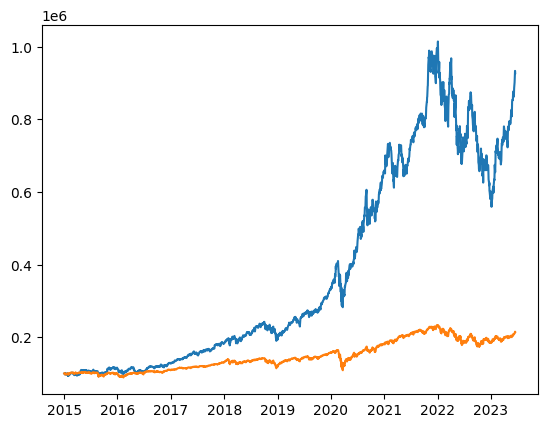

In [18]:
plt.plot(rdo_df[['Value', 'SP500']])
plt.show()